<div style="text-align:right;">Justine Charrel - Master 1 Internship</div>

This script is used to realize unsupervised machine learning (self-organizing maps) of temperature of ERA5.

### IMPORT

In [1]:
from netCDF4 import Dataset as ncfile
from minisom import MiniSom
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import cm
from pylab import pcolor
import matplotlib as mpl

### READ DATA

In [369]:
ppidir = '/lustre/storeB/users/justinec/master_internship/data/ERA5_MOSAiC/'
data_link  = ppidir + 'concatenated_ERA5_MOSAiC.nc'

dataset = ncfile(data_link,'r')    #dataset of radiosoundings of MOSAiC and ERA5

In [370]:
pres = dataset.variables['pres'][:]
data = dataset.variables['temp_era5'][:]
rh = dataset.variables['rh_era5'][:]

### SELF-ORGANIZING MAPS

#### Set hyperparameters

In [560]:
#int(np.sqrt(5*np.sqrt(len(data)))) #to determine max size of the SOM map (Vesanto,2005)
x = 4
y = 4
input_len = len(data[1])
iterations = 10000
sigma = 1 #1 seems great, let's see when changing others parameters
learning_rate = 0.5

#### Train and plot SOM

In [561]:
def train_som(x, y, input_len, sigma, learning_rate):
    
    # initialization of x*y SOM
    som = MiniSom(x=x, 
                  y=y, 
                  input_len=input_len, 
                  sigma=sigma, 
                  learning_rate=learning_rate)
    som.random_weights_init(data)
    
    # training
    start_time = time.time()
    som.train_random(data,iterations) # trains the SOM with 100 iterations
    elapsed_time = time.time() - start_time
    print(elapsed_time, "seconds")
    print('total_q_error :', som.quantization_error(data))
    
    return som

In [562]:
som = train_som(x, y, input_len, sigma, learning_rate)

1.2567052841186523 seconds
total_q_error : 9.0085150369957


In [563]:
def plot_som(som):
    bone()
    pcolor(som.distance_map().T)
    colorbar()

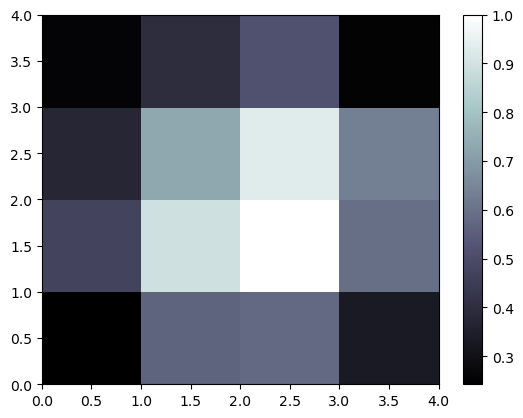

In [564]:
from pylab import plot,axis,show,pcolor,colorbar,bone
plot_som(som)

#### Tuning sigma by reducing quantization error with hyperopt.fmin

In [540]:
from hyperopt import fmin, tpe, hp

In [541]:
start_time = time.time()
best = fmin(
    fn=lambda sig: MiniSom(x=x, 
              y=y, 
              input_len=input_len, 
              sigma=sig, 
              learning_rate=learning_rate).quantization_error(data),
    space=hp.uniform("sig", 0.001, x / 2.01),
    algo=tpe.suggest,
    max_evals=200)
elapsed_time = time.time() - start_time
print(elapsed_time, "seconds")
print(best)

100%|██████| 200/200 [00:00<00:00, 356.85trial/s, best loss: 1334.1739181973353]
0.5639290809631348 seconds
{'sig': 0.81951897864766}


In [542]:
sigma = best['sig']
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}".format(x,y,len(data[1]),sigma,learning_rate))

x: 4
y: 4
input_len: 29
sigma: 0.81951897864766
learning_rate: 0.5


#### Train and plot SOM with new sigma setting

1.2724676132202148 seconds
total_q_error : 9.232508629535495


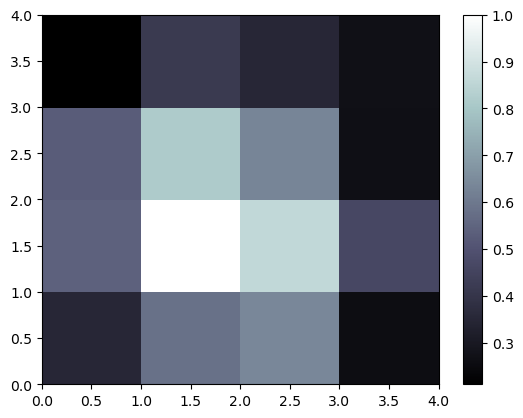

In [543]:
som = train_som(x, y, input_len, sigma, learning_rate)
plot_som(som)

#### Optimizing sigma and learning rate

In [565]:
from hyperopt import Trials, STATUS_OK

space={
        'sig': hp.uniform('sig', 0.001, 5),
        'learning_rate': hp.uniform('learning_rate', 0.001, 5)
    }
def som_fn(space):
    sig = space['sig']
    learning_rate = space['learning_rate']
    val = MiniSom(x=x, 
                  y=y, 
                  input_len=input_len, 
                  sigma=sig, 
                  learning_rate=learning_rate).quantization_error(data)
    #print(val)
    return {'loss': val, 'status': STATUS_OK}

trials =  Trials()
best = fmin(fn=som_fn,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print('best: {}'.format(best))
for i, trial in enumerate(trials.trials[:2]):
    print(i, trial)

100%|██████| 100/100 [00:00<00:00, 270.59trial/s, best loss: 1334.1164006300821]
best: {'learning_rate': 0.17987903517726686, 'sig': 1.2089889860070733}
0 {'state': 2, 'tid': 0, 'spec': None, 'result': {'loss': 1334.5162731039024, 'status': 'ok'}, 'misc': {'tid': 0, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [0], 'sig': [0]}, 'vals': {'learning_rate': [1.7205129763511393], 'sig': [4.107077227835491]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetime.datetime(2023, 4, 14, 15, 30, 37, 58000), 'refresh_time': datetime.datetime(2023, 4, 14, 15, 30, 37, 59000)}
1 {'state': 2, 'tid': 1, 'spec': None, 'result': {'loss': 1334.5489359241308, 'status': 'ok'}, 'misc': {'tid': 1, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'learning_rate': [1], 'sig': [1]}, 'vals': {'learning_rate': [4.392304142027612], 'sig': [1.6429635466659822]}}, 'exp_key': None, 'owner': None, 'version': 0, 'book_time': datetim

In [566]:
sigma = best['sig']
learning_rate = best['learning_rate']
print("x: {}\ny: {}\ninput_len: {}\nsigma: {}\nlearning_rate: {}".format(x,y,len(data[1]),sigma,learning_rate))

x: 4
y: 4
input_len: 29
sigma: 1.2089889860070733
learning_rate: 0.17987903517726686


#### Train and plot SOM with new sigma and learning rate settings

1.225928544998169 seconds
total_q_error : 9.268883448248006


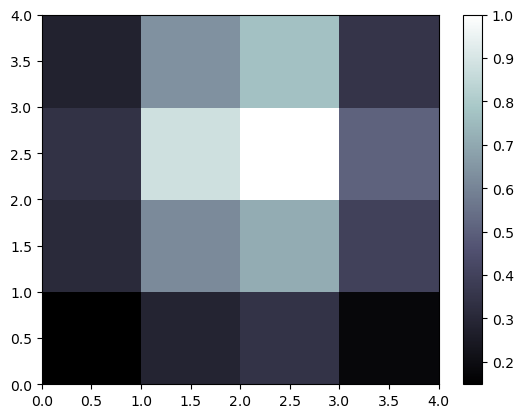

In [567]:
som = train_som(x, y, input_len, sigma, learning_rate)
plot_som(som)

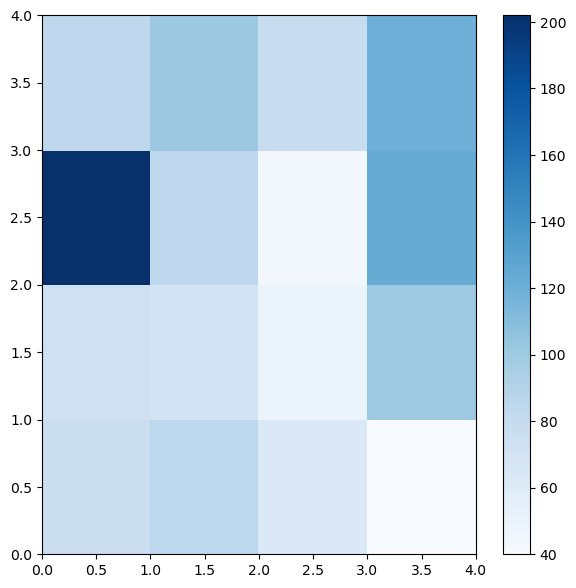

In [568]:
# NODES ACTIVATED MORE OFTEN (number of profiles in each neuron)

plt.figure(figsize=(7, 7))
frequencies = som.activation_response(data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

In [569]:
# parameters from minisom library
neuron_weights = som.get_weights()           # neuron weights for each neuron
win_map = som.win_map(data)                  # profiles sort by indices of neuron
nb_profiles = som.activation_response(data)  # number of profiles in each neuron

def quantization(self, data):
        """Assigns a code book (weights vector of the winning neuron)
        to each sample in data."""
        self._check_input_len(data)
        winners_coords = argmin(self._distance_from_weights(data), axis=1)
        return self._weights[unravel_index(winners_coords,self._weights.shape[:2])]
def get_weights(self):
        """Returns the weights of the neural network."""
        return self._weights

In [364]:
#######################
# COMPUTE SPECIFIC HUMIDITY 
#######################

data_celsius = data-273.15
e_s = 6.1094 * np.exp(17.625*data_celsius/(243.04+data_celsius))
e = e_s*rh/100
sh = 0.622*(e/pres)

In [10]:
som._distance_from_weights(data)

array([[75.84729763, 59.19014183, 11.43029403, ..., 33.26321354,
        68.69431779, 85.36598405],
       [73.96082951, 57.28559176, 10.16650765, ..., 35.64951783,
        70.58604716, 87.23096091],
       [73.11510711, 56.40063261,  9.88338905, ..., 37.20857525,
        71.70930338, 88.25482788],
       ...,
       [72.1006507 , 55.47436884,  9.44419507, ..., 38.37019512,
        72.68599884, 89.38783111],
       [72.28832578, 55.64651353,  9.55814835, ..., 38.24527804,
        72.46710348, 89.14694673],
       [71.10658103, 54.45640712,  8.85808717, ..., 39.34852887,
        73.66843186, 90.27901828]])

def _distance_from_weights(self, data):
        """Returns a matrix d where d[i,j] is the euclidean distance between
        data[i] and the j-th weight.
        """
        input_data = array(data)
        weights_flat = self._weights.reshape(-1, self._weights.shape[2])
        input_data_sq = power(input_data, 2).sum(axis=1, keepdims=True)
        weights_flat_sq = power(weights_flat, 2).sum(axis=1, keepdims=True)
        cross_term = dot(input_data, weights_flat.T)
        return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)

In [113]:
#dir(som)

#### ERRORS OVER ITERATIONS

In [479]:
total_topographic_error = som.topographic_error(data)
print(total_topographic_error)

0.18012866333095068


In [480]:
#som = MiniSom(x, y, input_len=input_len, sigma=sigma, learning_rate=learning_rate, random_seed=10)

max_iter = 10000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

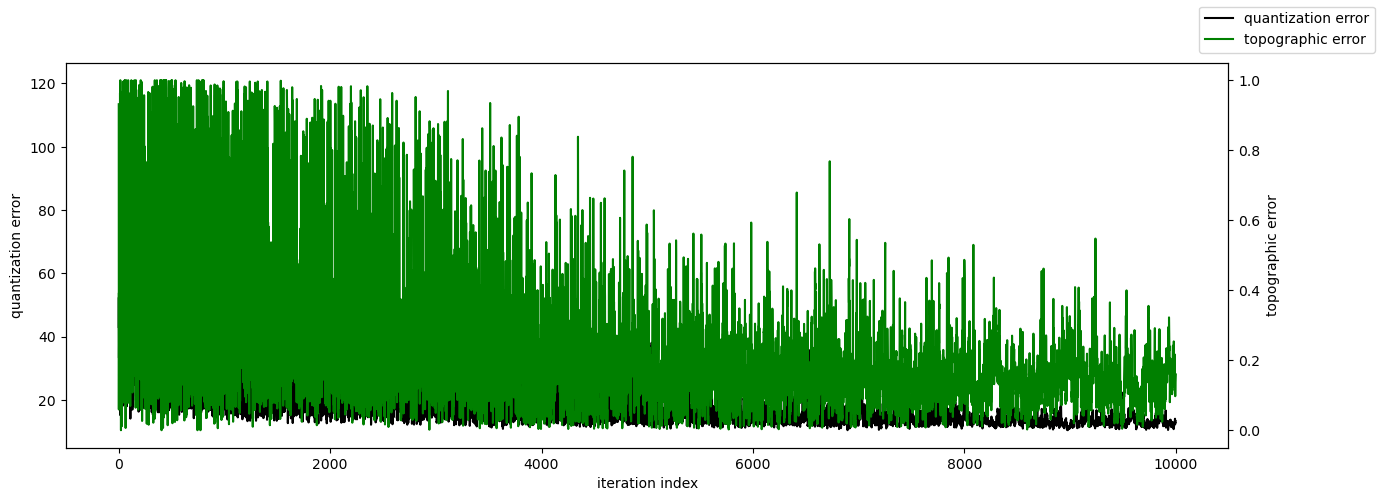

In [481]:
parameters = {'axes.labelsize':10, 'axes.titlesize':10, 'legend.fontsize':10, 'xtick.labelsize':10, 'ytick.labelsize':10, 
                  'legend.title_fontsize':10, 'figure.titlesize':25}
plt.rcParams.update(parameters)

fig, axs = plt.subplots(1,1,figsize=(15,5))
axs.plot(np.arange(max_iter), q_error, 'k', label='quantization error')
#axs.set_ylim(0,30)
#axs.set_xlim(-100,250)
axs2=axs.twinx()
axs2.plot(np.arange(max_iter), t_error, 'g', label='topographic error')
axs.set_ylabel('quantization error')
axs2.set_ylabel('topographic error')
axs.set_xlabel('iteration index')
fig.legend()
plt.show()

In [104]:
#standardise donnees

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(data))
StandardScaler()
print(scaler.mean_)
transf = scaler.transform(data)
print(transf)

StandardScaler()
[218.19980388 220.94681076 223.6944416  226.64466347 229.59557103
 232.34648831 235.09916666 237.58076735 240.06318343 242.28051435
 244.49816922 246.43026428 248.36308115 250.04060032 251.71929809
 253.18709156 254.65451803 255.98254844 257.31094811 258.44007208
 259.45325367 260.31826288 261.0458504  261.59565753 261.93168583
 261.97834971 261.5744116  261.03531431 260.6319865 ]
[[0.21878144 0.29600056 0.3586254  ... 0.33545694 0.49733344 0.43223135]
 [0.16444268 0.2916716  0.39988365 ... 0.34169935 0.46863479 0.39765236]
 [0.09269441 0.23755967 0.36246338 ... 0.28371073 0.46895907 0.49013484]
 ...
 [0.18898013 0.34948986 0.48649902 ... 0.23158945 0.40644444 0.46714996]
 [0.18761693 0.34696756 0.48298668 ... 0.19069815 0.37823434 0.45043181]
 [0.14354021 0.31834493 0.46914394 ... 0.22734468 0.39541178 0.46124944]]


#### QUANTIZATION ERROR AND MEAN SQUARED ERROR IN EACH NEURON

In [570]:
total_q_error = som.quantization_error(data) # total quantization error
total_mse = mean_squared_error(data,som.quantization(data))

winner_list = []
q_errors = np.zeros((x, y))
mse = np.zeros((x, y))
bmu = som.quantization(data) #BMU for each temperature profile

for ix in range(len(data)):
    winner = som.winner(data[ix])
    winner_list.append(winner)
    
    #Q-ERROR
    previous_value = q_errors[winner[0],winner[1]]
    new_value = np.linalg.norm(bmu[ix]-data[ix])
    mean = np.mean([previous_value,new_value])
    q_errors[winner[0],winner[1]] = mean

    #MSE
    previous_value2 = mse[winner[0],winner[1]]
    new_value2 = mean_squared_error(bmu[ix],data[ix])
    mean2 = np.mean([previous_value2,new_value2])
    mse[winner[0],winner[1]] = mean2
    
print('q_errors : \n', q_errors)
print('mse : \n', mse)
total_q_errors = np.mean(q_errors)
print('total q error of the SOM : {} ; total of the q errors of each neuron : {}'.format(total_q_error, total_q_errors))
total_mses = np.mean(mse)
print('total mse of the SOM : {} ; total of the mses of each neuron : {}'.format(total_mse, total_mses))

q_errors : 
 [[ 8.66170686  8.47122395  7.85937786 10.1421685 ]
 [15.98392778  7.74128497  8.18262601 10.78443541]
 [ 6.54895862  7.07855646 10.54424386  8.93046865]
 [13.14475817  4.79215482  5.13453367  9.7288808 ]]
mse : 
 [[2.67914575 2.58469942 2.1704037  3.71980332]
 [9.58110123 2.14178403 2.57621563 4.23658733]
 [1.59757817 1.73718328 4.01628747 2.76347047]
 [6.0938093  0.79188785 1.13406443 3.27227001]]
total q error of the SOM : 9.268883448248006 ; total of the q errors of each neuron : 8.983081649185255
total mse of the SOM : 3.434709356975546 ; total of the mses of each neuron : 3.1935182121700176


### PLOT

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


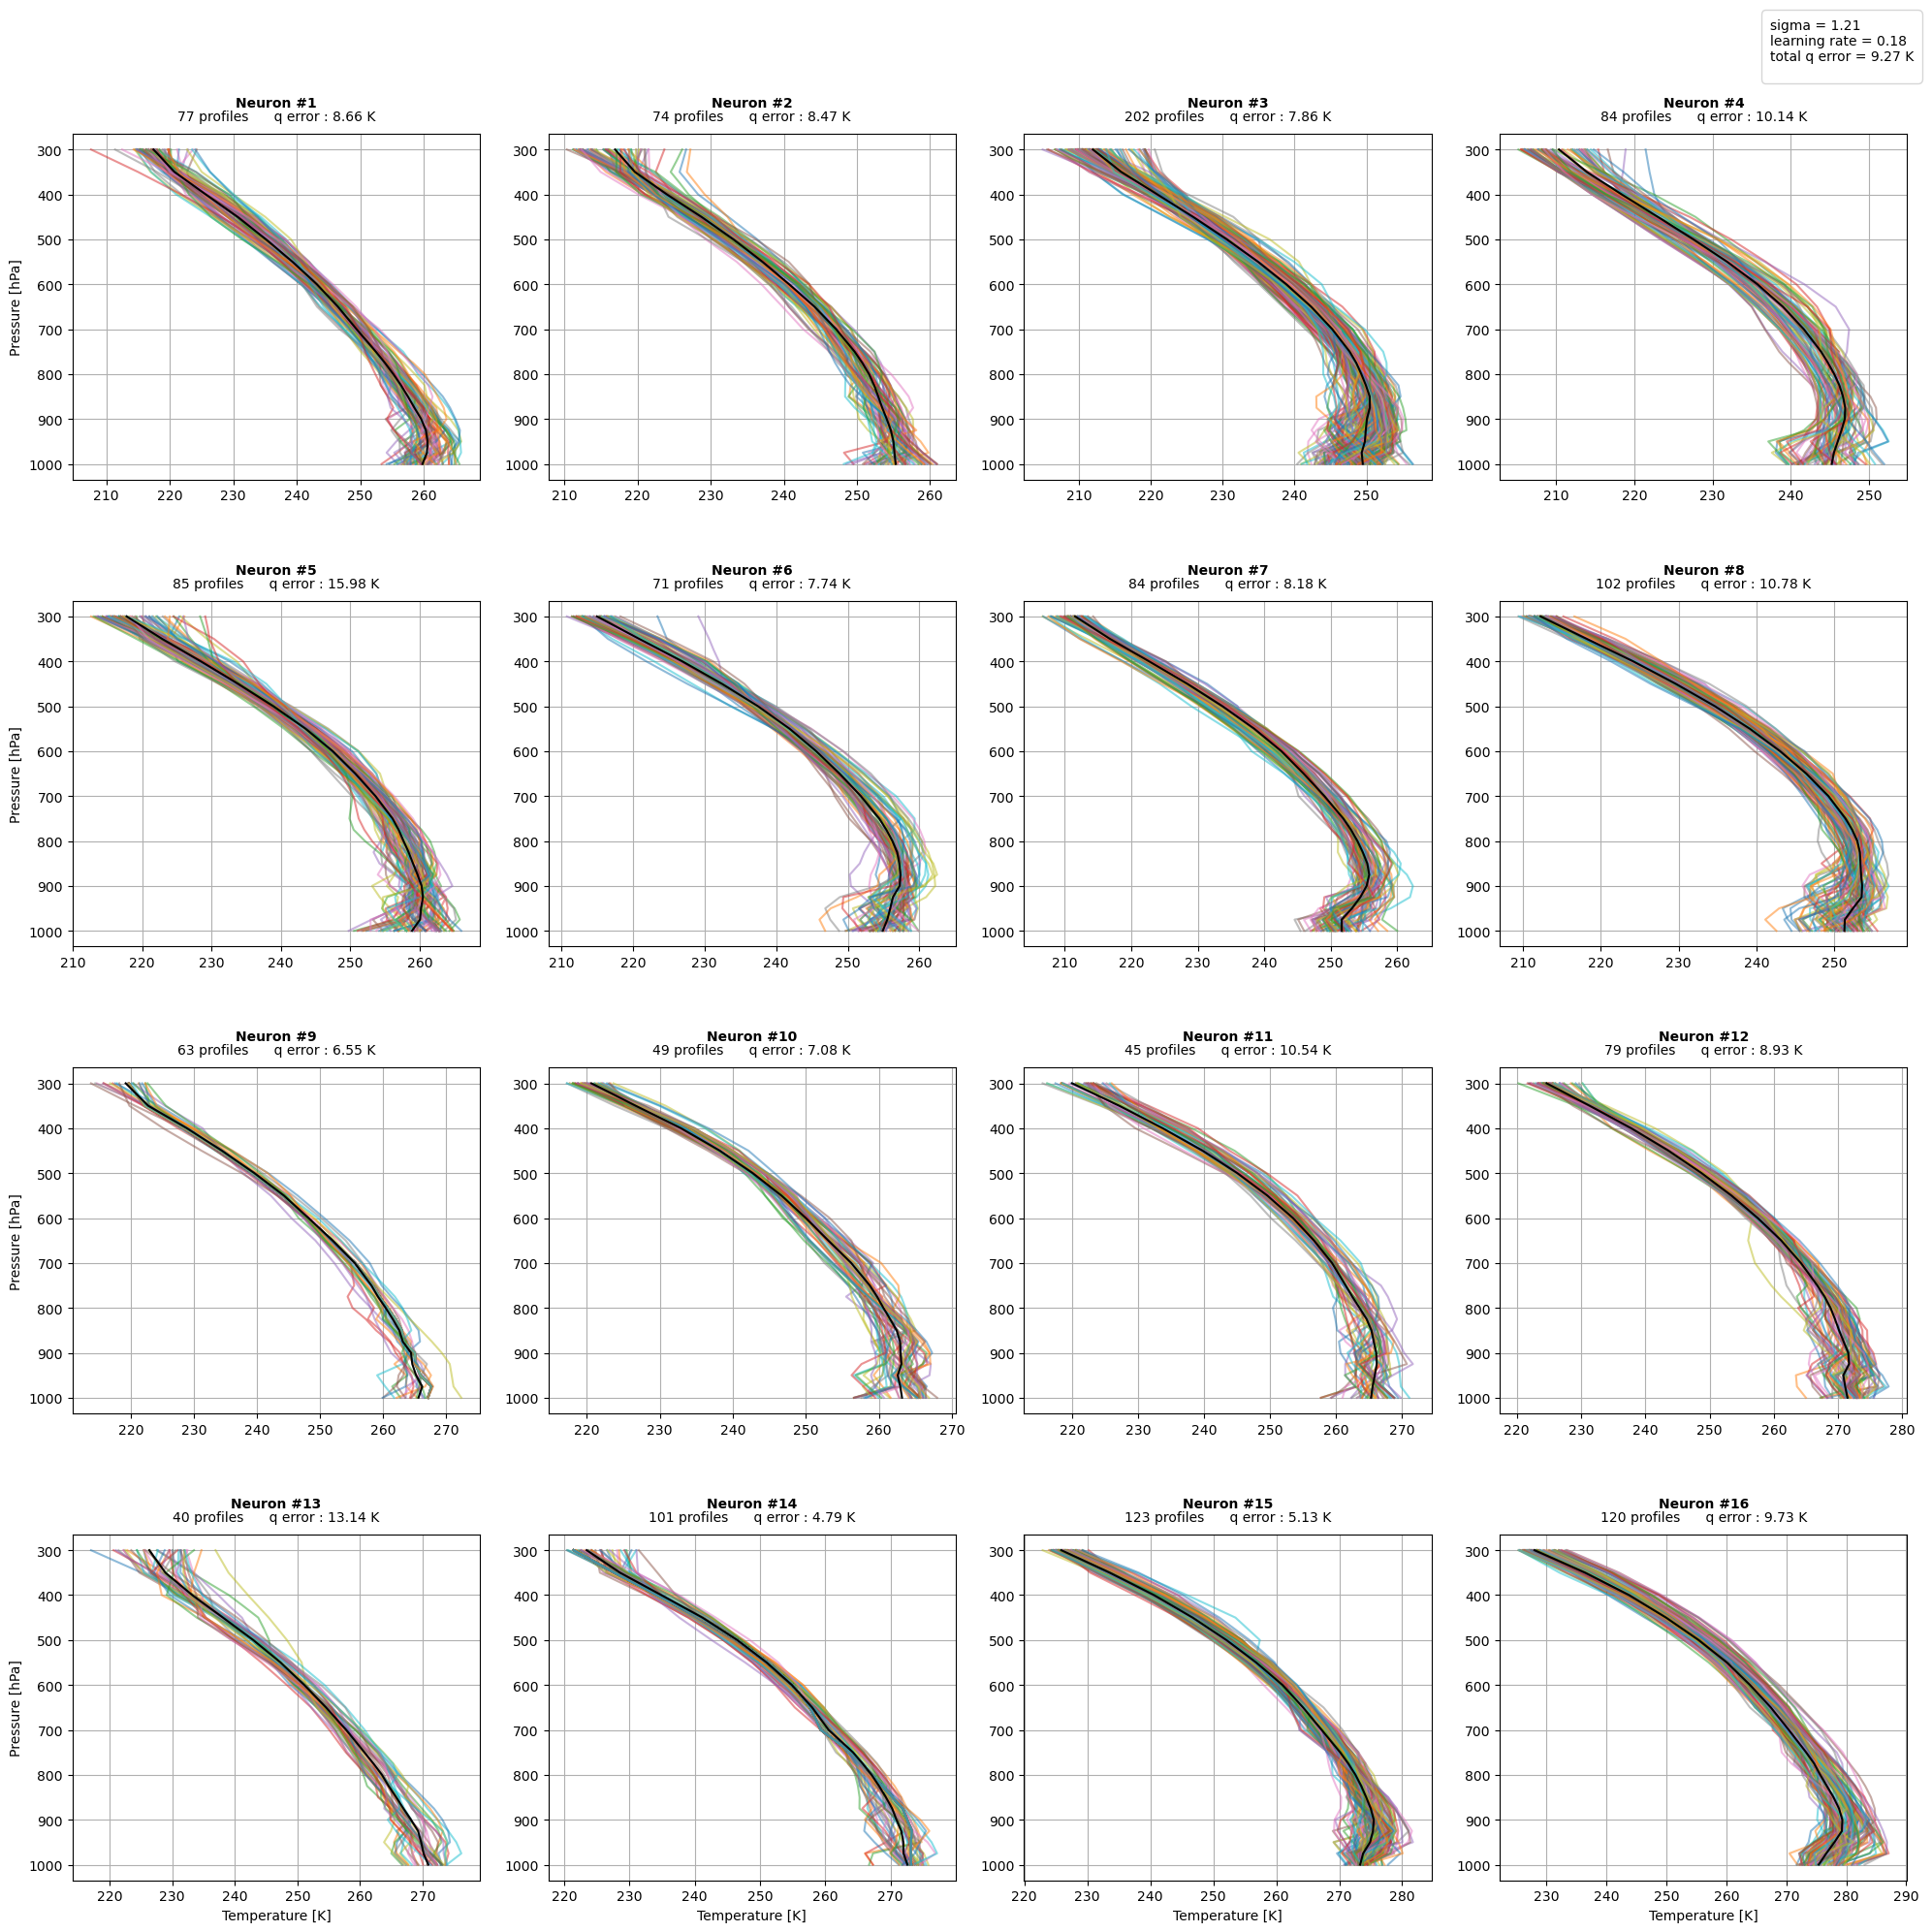

In [571]:
parameters = {'axes.labelsize':10, 'axes.titlesize':10, 'legend.fontsize':16, 'xtick.labelsize':10, 'ytick.labelsize':10, 
                  'legend.title_fontsize':10, 'figure.titlesize':25}
plt.rcParams.update(parameters)

fig, axs = plt.subplots(x,y,figsize=(20,20))
t=0
for i in range(0,x) :
     for n in range(0,y) :
        for m in range(len(win_map[(i,n)])) :
            axs[i,n].plot(win_map[(i,n)][m], pres, alpha=0.5)
        t = t+1
        axs[i,n].plot(neuron_weights[i][n], pres, 'k')
        axs[i,n].invert_yaxis()
        axs[i,n].grid()
        axs[i,n].set_title('Neuron #'+str(t), fontsize=10, pad=20, weight='bold')
        axs[i,n].text(0.5,1.05, str(int(nb_profiles[i][n])) + ' profiles      q error : ' + str(np.round(q_errors[i,n], 2)) + ' K' ,horizontalalignment='center',verticalalignment='center',transform = axs[i,n].transAxes)
        if n==0 :
            axs[i,n].set_ylabel('Pressure [hPa]')
        if i>2 :
            axs[i,n].set_xlabel('Temperature [K]')
            
fig.tight_layout()        
fig.subplots_adjust(top=0.93, hspace=0.35)
fig.legend(title='sigma = {} \nlearning rate = {} \ntotal q error = {} K'.format(np.round(sigma,2), np.round(learning_rate,2), np.round(total_q_error,2)))
path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_SOM/'
plt.savefig(path_fig+'ERA5_temp_SOM_s'+str(sigma)+'_lt'+str(learning_rate)+'_i'+str(iterations)+'.png',dpi=300)